In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
# from statsmodels.genmod.generalized_estimating_equations import GEE
# from statsmodels.genmod.cov_struct import (Exchangeable,
#     Independence,Autoregressive)
# from statsmodels.genmod.families import Poisson


#### Demographic Data Processing


In [2]:
def remove_minus(x):
    if (x == "-"):
        return "NaN"
    else:
        return x.replace("-", "").replace("+", "").replace(",", "")

In [3]:
#this data is for 11 variables, all census tracts in California, using ACS 2009 5YR estimates 

demog_data_path = '/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/demographic_data/'
#get percentages of each race

race = pd.read_csv(demog_data_path+ 'ACS_09_5YR_B03002_race_clean.csv')
race["Percent NH White alone"] = race["Estimate; Not Hispanic or Latino: - White alone"]/race["Estimate; Total:"]
race["Percent NH Black or African African alone"] = race["Estimate; Not Hispanic or Latino: - Black or African American alone"]/race["Estimate; Total:"]
race["Percent NH Asian alone"] = race["Estimate; Not Hispanic or Latino: - Asian alone"]/race["Estimate; Total:"]
race["Percent Hispanic"] = race["Estimate; Hispanic or Latino:"]/race["Estimate; Total:"]


edu = pd.read_csv(demog_data_path+ 'ACS_09_5YR_S1501_bach_clean.csv')
edu = edu.rename({"Percent of population 25 years and over  with Bachelor\'s degree": "Percent of population 25 years and over with Bachelor\'s degree"}, axis=1)
edu["Percent of population 25 years and over with Bachelor\'s degree"] = edu["Percent of population 25 years and over with Bachelor\'s degree"].apply(lambda x: x.replace("+", "").replace("-", "NaN"))
edu["Percent of population 25 years and over with Bachelor\'s degree"] = edu["Percent of population 25 years and over with Bachelor\'s degree"].astype(float).dropna()


#get rid of + and ***
hvalue = pd.read_csv(demog_data_path+ 'ACS_09_5YR_B25077_hvalue_clean.csv')
hvalue["Estimate; Median value (dollars)"] = hvalue["Estimate; Median value (dollars)"].apply(lambda x: x.replace("+", "").replace("-", "NaN").replace(",", ""))
hvalue["Estimate; Median value (dollars)"] = hvalue["Estimate; Median value (dollars)"].astype(float)

#hvalue["Estimate; Median value (dollars)"] = hvalue["Estimate; Median value (dollars)"].astype(float).dropna()

#add attached and detached and find the %
single = pd.read_csv(demog_data_path+ 'ACS_09_5YR_B25024_singlefam_clean.csv')
single["Total Single Family"] = single["Estimate; 1, attached"]+ single["Estimate; 1, detached"]
single["% Single Family"] = single["Total Single Family"] / single["Estimate; Total:"]
#single["Tract"] = (single["Id2"].astype(str)).apply(lambda x: int(x[4:8]))

poverty = pd.read_csv(demog_data_path+"ACS_09_5YR_S1702_povertyfam_clean.csv")

# poverty = pd.read_csv(demog_data_path+ "ACS_17_5YR_S1701_poverty_clean.csv")
poverty['All families - Percent  below poverty level; Estimate; Families'] = poverty['All families - Percent  below poverty level; Estimate; Families'].apply(lambda x: x.replace("+", "").replace("-", "NaN"))
poverty['All families - Percent  below poverty level; Estimate; Families'] = poverty['All families - Percent  below poverty level; Estimate; Families'].astype(float).dropna()



units = pd.read_csv(demog_data_path+'ACS_09_5YR_B25001_units_clean.csv')
#units["Tract"] = (units["Id2"].astype(str)).apply(lambda x: int(x[4:8]))


#find % renter occupied
tenure = pd.read_csv(demog_data_path+ 'ACS_09_5YR_B25003_tenure_clean.csv')
tenure["% Renter Occupied"] = tenure["Estimate; Renter occupied"]/tenure["Estimate; Total:"]
tenure["% Owner Occupied"] = tenure["Estimate; Owner occupied"]/tenure["Estimate; Total:"]


income = pd.read_csv(demog_data_path + 'ACS_09_5YR_S1903_income.csv')
income["Median income (dollars); All households"] = income["Median income (dollars); All households"].apply(remove_minus)

income["Median income (dollars); All households"] = income["Median income (dollars); All households"].astype(float)

print("total counties in the bay represented in ACS data", len(income))





total counties in the bay represented in ACS data 7049


#### Create Controlled features dataframe

In [4]:
race_units_merged = race.merge(units, how='left', left_on="Id2", right_on="Id2")
print("race and units merged", "length", len(race_units_merged))
#print("race and units merged", "dtypes", race_units_merged.dtypes)

edu_merged = race_units_merged.merge(edu, how='left', left_on="Id2", right_on="Id2")
print("edu merged", "length", len(edu_merged))
#print("edu merged", "dtypes", edu_merged.dtypes)

income_merged = edu_merged.merge(income, how='left', left_on="Id2", right_on="Id2")
print("income merged", "length", len(income_merged))
#print("income", "dtypes", income_merged.dtypes)

poverty_merged = income_merged.merge(poverty, how='left', left_on="Id2", right_on="Id2")
print("poverty merged", "length", len(poverty_merged))
#print("poverty", "dtypes", poverty_merged.dtypes)

hvalue_merged = poverty_merged.merge(hvalue, how='left', left_on="Id2", right_on="Id2")
print("hvalue merged", "length", len(hvalue_merged))
#print("hvalue", "dtypes", hvalue_merged.dtypes)

single_merged = hvalue_merged.merge(single, how='left', left_on="Id2", right_on="Id2")
print("single merged", "length", len(single_merged))
#print("singe merged", "dtypes", single_merged.dtypes)


all_demog_vars = single_merged.merge(tenure, how='left', left_on="Id2", right_on="Id2")
print("tenure merged", "length", len(all_demog_vars))
all_demog_vars.head()


race and units merged length 7049
edu merged length 7049
income merged length 7049
poverty merged length 7049
hvalue merged length 7049
single merged length 7049
tenure merged length 7049


,Id2,Geography_x,Estimate; Total:_x,Margin of Error; Total:_x,Estimate; Not Hispanic or Latino:,Estimate; Not Hispanic or Latino: - White alone,Estimate; Not Hispanic or Latino: - Black or African American alone,Estimate; Not Hispanic or Latino: - Asian alone,Estimate; Hispanic or Latino:,Estimate; Hispanic or Latino: - White alone,...,% Single Family,Geography_y,Estimate; Total:,Margin of Error; Total:,Estimate; Owner occupied,Margin of Error; Owner occupied,Estimate; Renter occupied,Margin of Error; Renter occupied,% Renter Occupied,% Owner Occupied
0,6001400100,"Census Tract 4001, Alameda County, California",2872,233,2851,2209,119,318,21,15,...,0.912439,"Census Tract 4001, Alameda County, California",1308,108,1171,107,137,74,0.104740,0.895260
1,6001400200,"Census Tract 4002, Alameda County, California",2076,165,1854,1594,47,144,222,56,...,0.665236,"Census Tract 4002, Alameda County, California",902,42,593,71,309,73,0.342572,0.657428
2,6001400300,"Census Tract 4003, Alameda County, California",4964,369,4541,3545,492,375,423,247,...,0.478758,"Census Tract 4003, Alameda County, California",2626,132,1064,150,1562,182,0.594821,0.405179
3,6001400400,"Census Tract 4004, Alameda County, California",4223,553,3957,2948,391,330,266,149,...,0.555446,"Census Tract 4004, Alameda County, California",1964,87,852,133,1112,152,0.566191,0.433809
4,6001400500,"Census Tract 4005, Alameda County, California",3759,308,3323,1577,1303,249,436,179,...,0.444380,"Census Tract 4005, Alameda County, California",1686,82,738,102,948,119,0.562278,0.437722


In [5]:
all_demog_vars.columns
all_demog_vars_1 = all_demog_vars[['Id2','Percent of population 25 years and over with Bachelor\'s degree', 
      'All families - Percent  below poverty level; Estimate; Families', 
      '% Single Family', '% Owner Occupied', 'Percent NH White alone',
       'Percent NH Black or African African alone', 'Percent NH Asian alone',
       'Percent Hispanic', 'Estimate; Total Number of Housing Units', 'Estimate; Median value (dollars)', 
        'Median income (dollars); All households']]
all_demog_vars_1_renamed = all_demog_vars_1.rename({'All families - Percent  below poverty level; Estimate; Families': "% below poverty level",
              'Estimate; Total Number of Housing Units': 'Total number of housing units',
              'Estimate; Median value (dollars)': "Median home value",
              'Median income (dollars); All households': "Median income", 'Id2': "Geoid"}, axis=1)


# print("num tracts", len(all_demog_vars))
      
all_demog_vars_1_renamed.head()





,Geoid,Percent of population 25 years and over with Bachelor's degree,% below poverty level,% Single Family,% Owner Occupied,Percent NH White alone,Percent NH Black or African African alone,Percent NH Asian alone,Percent Hispanic,Total number of housing units,Median home value,Median income
0,6001400100,34.5,3.1,0.912439,0.895260,0.769150,0.041435,0.110724,0.007312,1439,1000000.0,186439.0
1,6001400200,37.6,0.0,0.665236,0.657428,0.767823,0.022640,0.069364,0.106936,932,909500.0,122647.0
2,6001400300,32.1,6.9,0.478758,0.405179,0.714142,0.099114,0.075544,0.085214,2801,718100.0,66638.0
3,6001400400,44.0,4.0,0.555446,0.433809,0.698082,0.092588,0.078143,0.062988,2020,790500.0,80391.0
4,6001400500,28.1,6.0,0.444380,0.437722,0.419526,0.346635,0.066241,0.115988,1735,572000.0,50658.0


#### Get only Bay Area counties

In [6]:
county_codes = ['6001', '6013', '6041', '6055', '6075', '6081', '6085', '6097', '6095']


In [7]:
all_demog_vars_bay = all_demog_vars_1_renamed[all_demog_vars_1_renamed["Geoid"].apply(lambda x: str(x)[:4]).isin(county_codes)]
print("num bay area tracts represented in the ACS data", len(all_demog_vars_bay))
all_demog_vars_bay.head()


num bay area tracts represented in the ACS data 1405


,Geoid,Percent of population 25 years and over with Bachelor's degree,% below poverty level,% Single Family,% Owner Occupied,Percent NH White alone,Percent NH Black or African African alone,Percent NH Asian alone,Percent Hispanic,Total number of housing units,Median home value,Median income
0,6001400100,34.5,3.1,0.912439,0.895260,0.769150,0.041435,0.110724,0.007312,1439,1000000.0,186439.0
1,6001400200,37.6,0.0,0.665236,0.657428,0.767823,0.022640,0.069364,0.106936,932,909500.0,122647.0
2,6001400300,32.1,6.9,0.478758,0.405179,0.714142,0.099114,0.075544,0.085214,2801,718100.0,66638.0
3,6001400400,44.0,4.0,0.555446,0.433809,0.698082,0.092588,0.078143,0.062988,2020,790500.0,80391.0
4,6001400500,28.1,6.0,0.444380,0.437722,0.419526,0.346635,0.066241,0.115988,1735,572000.0,50658.0


#### Merge Demographic features with neighbors dataframe to contribute CRA eligibility information by tract and exclude CTs without oppositely coded neighbors

Universe: all of the CTs in the 9 county bay area that had loan activity have oppositely coded neighbors. The boolean_tracts_all_2009.csv file includes all the tracts that have oppositely coded neighbors and their CRA eligibility.



In [8]:
data_path = '/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/neighbors/'
cra_elig_neighbors = pd.read_csv(data_path+ 'boolean_tracts_all_2009.csv')
print("num all tracts in the HMDA data that have at least one oppositely coded neighbor", len(cra_elig_neighbors))


num all tracts in the HMDA data that have at least one oppositely coded neighbor 801


In [9]:
demog_with_cra = pd.merge(all_demog_vars_bay, cra_elig_neighbors, how='right', left_on='Geoid', right_on='Geoid')
print("num all tracts in the HMDA data that have at least one oppositely coded neighbor", len(demog_with_cra))

demog_with_cra.head()


num all tracts in the HMDA data that have at least one oppositely coded neighbor 801


,Geoid,Percent of population 25 years and over with Bachelor's degree,% below poverty level,% Single Family,% Owner Occupied,Percent NH White alone,Percent NH Black or African African alone,Percent NH Asian alone,Percent Hispanic,Total number of housing units,Median home value,Median income,Year_x,Tract_y,type,County,CRA Eligible
0,6001400100,34.5,3.1,0.912439,0.895260,0.769150,0.041435,0.110724,0.007312,1439,1000000.0,186439.0,2009,4001.0,high,Alameda County,not eligible
1,6001400300,32.1,6.9,0.478758,0.405179,0.714142,0.099114,0.075544,0.085214,2801,718100.0,66638.0,2009,4003.0,mid,Alameda County,not eligible
2,6001400400,44.0,4.0,0.555446,0.433809,0.698082,0.092588,0.078143,0.062988,2020,790500.0,80391.0,2009,4004.0,mid,Alameda County,not eligible
3,6001400500,28.1,6.0,0.444380,0.437722,0.419526,0.346635,0.066241,0.115988,1735,572000.0,50658.0,2009,4005.0,mod,Alameda County,eligible
4,6001400600,51.9,26.4,0.632653,0.470756,0.338305,0.473150,0.032220,0.059666,784,586700.0,39802.0,2009,4006.0,mod,Alameda County,eligible


#### Get total number and percentages of loans data from HMDA files
This is currently for 2009, but next step is to do it for the average of the recovery period 2013-2017


Universe: all of the CTs in the 9 county bay area that had loan activity during 2009

In [12]:
filepath = '/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/parsed_data_1/'
Alameda = pd.read_csv(filepath+'Alameda_2009_parsed.csv')
Alameda["Geoid"] = Alameda["Tract"].apply(lambda x: int(x*100 + 6001000000))

ContraCosta = pd.read_csv(filepath+'ContraCosta_2009_parsed.csv')
ContraCosta["Geoid"] = ContraCosta["Tract"].apply(lambda x: int(x*100 + 6013000000))

Napa = pd.read_csv(filepath+'Napa_2009_parsed.csv')
Napa["Geoid"] = Napa["Tract"].apply(lambda x: int(x*100 + 6055000000))

Marin = pd.read_csv(filepath+'Marin_2009_parsed.csv')
Marin["Geoid"] = Marin["Tract"].apply(lambda x: int(x*100 + 6041000000))

SanMateo = pd.read_csv(filepath+'SanMateo_2009_parsed.csv')
SanMateo["Geoid"] = SanMateo["Tract"].apply(lambda x: int(x*100 + 6081000000))

SanFrancisco = pd.read_csv(filepath+'SanFrancisco_2009_parsed.csv')
SanFrancisco["Geoid"] = SanFrancisco["Tract"].apply(lambda x: int(x*100 + 6075000000))

Solano = pd.read_csv(filepath+'Solano_2009_parsed.csv')
Solano["Geoid"] = Solano["Tract"].apply(lambda x: int(x*100 + 6095000000))

SantaClara = pd.read_csv(filepath+'SantaClara_2009_parsed.csv')
SantaClara["Geoid"] = SantaClara["Tract"].apply(lambda x: int(x*100 + 6085000000))

Sonoma = pd.read_csv(filepath+'Sonoma_2009_parsed.csv')
Sonoma["Geoid"] = Sonoma["Tract"].apply(lambda x: int(x*100 + 6097000000))

counties = [Alameda, ContraCosta, Napa, Marin, SanMateo, SanFrancisco,Solano,SantaClara, Sonoma]

bay_counties_loans = pd.concat(counties).reset_index(drop=True)
bay_counties_loans["Total Loans"] = bay_counties_loans['# HI borrower, LI tract'] + bay_counties_loans['# HI borrower, HI tract']+ bay_counties_loans['# LI borrower, LI tract']
+ bay_counties_loans['# LI borrower, HI tract']
bay_counties_loans = bay_counties_loans.drop("Tract", axis=1)


#### Merge Loans Data with cra_demog features

In [13]:
allvars_2009 = pd.merge(demog_with_cra, bay_counties_loans, how="left", left_on='Geoid', right_on='Geoid').drop('CRA Eligible_y', axis=1)
allvars_2009['CRA'] = allvars_2009['CRA Eligible_x'].apply(lambda x: 1 if x == 'eligible' else 0)
#allvars_2009.to_csv("/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/all_vars2009.csv")
print("number of observations/tracts", len(allvars_2009))




number of observations/tracts 801


In [14]:
nonans = allvars_2009.dropna()
print("number of non-nan obs: ", len(nonans))

number of non-nan obs:  790


In [15]:
def normalize_columns(data, mean_df, std_df):
    '''
    Input:
      data (data frame): contains only numeric columns
    Output:
      data frame, the same data, except each column is standardized 
      to have 0-mean and unit variance
    '''
    normalized_data=(data-mean_df.mean())/std_df.std()

    return normalized_data

In [16]:
# def unnormalize_columns(data, mean_df, std_df):
#     unnormalized_data=(data*std_df.std())+mean_df.mean()

#     return unnormalized_data

#### Model 1: Minority vs. num loans

In [17]:
def dummy_var(row):
    dummy = 0
    if (row['Percent NH White alone'] >= 0.50):
        dummy = 1
    else:
        dummy = 0
    return dummy

In [18]:
#drop observations with NaN values
X_vars_models = nonans.loc[:, ~nonans.columns.isin(['Geoid', 'Total Loans','County_y', 'County_x',
         'type_y', 'type_x', 'CRA Eligible_x', 'Year', "Year_x", "Tract_y", '% HI borrower, LI tract',
       '# HI borrower, LI tract', '% HI borrower, HI tract',
       '# HI borrower, HI tract', '% LI borrower, LI tract',
       '# LI borrower, LI tract', '%LI borrower, HI tract',
       '# LI borrower, HI tract' ])]
Y_vars_models = nonans['Total Loans']
X_vars_models['Minority'] = X_vars_models.apply(lambda x: dummy_var(x), axis=1)
print("regression num observations after dropping nans", len(X_vars_models))

regression num observations after dropping nans 790


/Users/ameliabaum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
#normalize the data before perfoming the regression- currently this is normalizing 2 binary variables (CRA and minority),
#which is a call I intentionally made, but is a fairly subjective call and could be changed.
X_vars_models_normal = normalize_columns(X_vars_models, X_vars_models, X_vars_models)
Y_vars_models_normal = normalize_columns(Y_vars_models, Y_vars_models, Y_vars_models)
X_vars_models_normal.head()

,Percent of population 25 years and over with Bachelor's degree,% below poverty level,% Single Family,% Owner Occupied,Percent NH White alone,Percent NH Black or African African alone,Percent NH Asian alone,Percent Hispanic,Total number of housing units,Median home value,Median income,CRA,Minority
0,1.173649,-0.692232,1.170598,1.659406,1.599032,-0.386909,-0.560245,-1.359381,-0.533980,2.173141,4.666265,-0.811683,1.319412
1,0.941447,-0.197604,-0.412884,-0.600077,1.356233,0.068573,-0.764368,-0.929743,0.873962,0.686456,-0.091198,-0.811683,1.319412
2,2.092781,-0.575083,-0.132877,-0.468083,1.285348,0.017043,-0.749284,-1.052318,0.066618,1.068279,0.454952,-0.811683,1.319412
3,0.554443,-0.314753,-0.538404,-0.450038,0.055852,2.023203,-0.818345,-0.760016,-0.227995,-0.084047,-0.725786,1.230449,-0.756954
4,2.857113,2.340618,0.149027,-0.297739,-0.302644,3.022275,-1.015744,-1.070642,-1.211074,-0.006522,-1.156893,1.230449,-0.756954


In [22]:
X_m1_normal_constant = sm.add_constant(X_vars_models_normal)
m1 = sm.regression.linear_model.OLS(Y_vars_models_normal, X_vars_models_normal[['Minority', "CRA"]])
results_m1 = m1.fit()
print(results_m1.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Loans   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5772
Date:                Tue, 05 Feb 2019   Prob (F-statistic):              0.562
Time:                        22:57:33   Log-Likelihood:                -1119.9
No. Observations:                 790   AIC:                             2244.
Df Residuals:                     788   BIC:                             2253.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Minority      -0.0391      0.038     -1.020      0.3

In [23]:
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/2009_minority_m1.html', 'w') as outfile:
    outfile.write(results_m1.summary().as_html())
      
  

#### Model 2


In [24]:
X_m2_normal_constant = sm.add_constant(X_vars_models_normal)
m2 = sm.regression.linear_model.OLS(Y_vars_models_normal, X_m2_normal_constant[['Minority', 'Percent NH White alone', "CRA"]])

results_m2 = m2.fit()

print(results_m2.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Loans   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4540
Date:                Tue, 05 Feb 2019   Prob (F-statistic):              0.715
Time:                        22:57:41   Log-Likelihood:                -1119.8
No. Observations:                 790   AIC:                             2246.
Df Residuals:                     787   BIC:                             2260.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Minority                  -0

In [25]:
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/2009_minnhw_m2.html', 'w') as outfile:
    outfile.write(results_m2.summary().as_html())
    
    

#### Model 3



In [26]:
X_m3_normal_constant = sm.add_constant(X_vars_models_normal)
m3 = sm.regression.linear_model.OLS(Y_vars_models_normal, X_m3_normal_constant[['Minority', 'Percent Hispanic', "CRA"]])
results_m3 = m3.fit()

print(results_m3.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Loans   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.466
Date:                Tue, 05 Feb 2019   Prob (F-statistic):             0.0159
Time:                        22:57:53   Log-Likelihood:                -1115.3
No. Observations:                 790   AIC:                             2237.
Df Residuals:                     787   BIC:                             2251.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Minority            -0.0024      0.040  

In [27]:
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/2009_minh_m3.html', 'w') as outfile:
    outfile.write(results_m3.summary().as_html())



#### Model 4

In [28]:
X_m4_normal_constant = sm.add_constant(X_vars_models_normal)
m4 = sm.regression.linear_model.OLS(Y_vars_models_normal, X_m4_normal_constant[['Minority', 'Percent NH Asian alone', "CRA"]])
results_m4 = m4.fit()
print(results_m4.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Loans   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.860
Date:                Tue, 05 Feb 2019   Prob (F-statistic):             0.0361
Time:                        22:58:01   Log-Likelihood:                -1116.2
No. Observations:                 790   AIC:                             2238.
Df Residuals:                     787   BIC:                             2252.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Minority                  -0

In [29]:
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/2009_minnha_m4.html', 'w') as outfile:
    outfile.write(results_m4.summary().as_html())

#### Model 5

In [30]:
X_m5_normal_constant = sm.add_constant(X_vars_models_normal)
m5 = sm.regression.linear_model.OLS(Y_vars_models_normal, X_m5_normal_constant[['Minority', 'Percent NH Black or African African alone', "CRA"]])
results_m5 = m5.fit()
print(results_m5.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Loans   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3896
Date:                Tue, 05 Feb 2019   Prob (F-statistic):              0.761
Time:                        22:58:15   Log-Likelihood:                -1119.9
No. Observations:                 790   AIC:                             2246.
Df Residuals:                     787   BIC:                             2260.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [31]:
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/2009_minnhb_m5.html', 'w') as outfile:
    outfile.write(results_m5.summary().as_html())

#### Model 6: Housing units


In [32]:
X_m6_normal_constant = sm.add_constant(X_vars_models_normal)
m6 = sm.regression.linear_model.OLS(Y_vars_models_normal, X_m6_normal_constant[['Total number of housing units', "CRA"]])
results_m6 = m6.fit()
print(results_m6.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Loans   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     246.1
Date:                Tue, 05 Feb 2019   Prob (F-statistic):           8.93e-84
Time:                        22:58:23   Log-Likelihood:                -928.75
No. Observations:                 790   AIC:                             1861.
Df Residuals:                     788   BIC:                             1871.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Total number o

In [33]:
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/2009_units_m6.html', 'w') as outfile:
    outfile.write(results_m6.summary().as_html())

#### Model 7:  housing market features


In [34]:
X_m7_normal_constant = sm.add_constant(X_vars_models_normal)
m7 = sm.regression.linear_model.OLS(Y_vars_models_normal, X_m7_normal_constant[['% Single Family','% Owner Occupied',
                                                                         'Median home value', "CRA"]])
results_m7 = m7.fit()
print(results_m7.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Loans   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     16.96
Date:                Tue, 05 Feb 2019   Prob (F-statistic):           2.39e-13
Time:                        22:58:31   Log-Likelihood:                -1087.8
No. Observations:                 790   AIC:                             2184.
Df Residuals:                     786   BIC:                             2202.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
% Single Family      -0.0436      0.06

In [35]:
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/2009_housing_m7.html', 'w') as outfile:
    outfile.write(results_m7.summary().as_html())

#### Model 8: socioeconomic features


In [36]:
X_m8_normal_constant = sm.add_constant(X_vars_models_normal)
m8 = sm.regression.linear_model.OLS(Y_vars_models_normal, X_m8_normal_constant[['Median income','Percent of population 25 years and over with Bachelor\'s degree',
                                                                         '% below poverty level', "CRA"]])
results_m8 = m8.fit()
print(results_m8.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Loans   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     14.58
Date:                Tue, 05 Feb 2019   Prob (F-statistic):           1.71e-11
Time:                        22:58:40   Log-Likelihood:                -1092.2
No. Observations:                 790   AIC:                             2192.
Df Residuals:                     786   BIC:                             2211.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

#### Plots

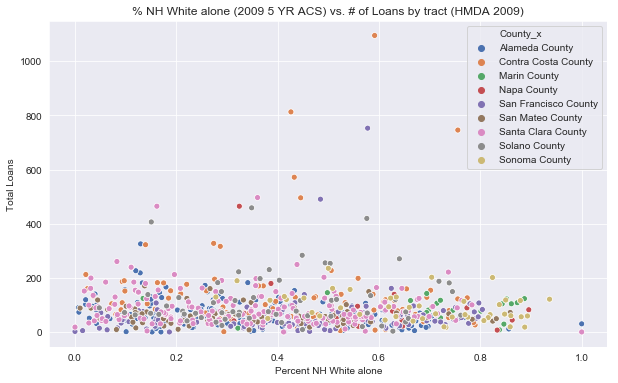

In [61]:
# plt.scatter(allvars_2009['Percent NH White alone'], allvars_2009["Total Loans"], c='orangered', alpha='0.5')
# plt.title('% NH White alone (2009 5 YR ACS) vs. # of Loans by tract (HMDA 2009)')
# plt.xlabel('Percent NH White alone')
# plt.ylabel('# of total loans')
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=(10,6))
plt.title('% NH White alone (2009 5 YR ACS) vs. # of Loans by tract (HMDA 2009)')
plot = sns.scatterplot(allvars_2009['Percent NH White alone'], allvars_2009['Total Loans'],
     hue = allvars_2009["County_x"], legend='brief', markers='p', palette= "deep")          
plt.legend(bbox_to_anchor=(1,1), loc=1)

plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/nhw_vs_loans_09.png')


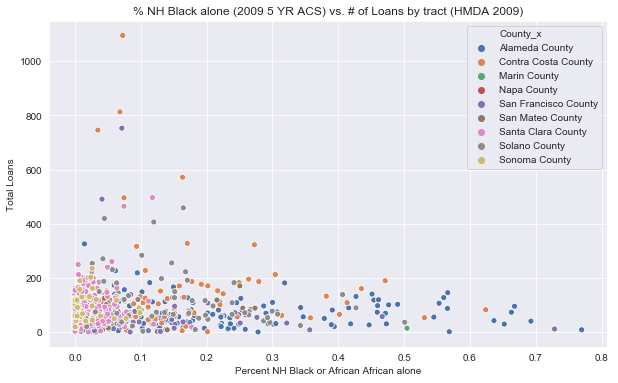

In [65]:
plt.figure(figsize=(10,6))
plt.title('% NH Black alone (2009 5 YR ACS) vs. # of Loans by tract (HMDA 2009)')
plot = sns.scatterplot(allvars_2009['Percent NH Black or African African alone'], allvars_2009['Total Loans'],
     hue = allvars_2009["County_x"], legend='brief', markers='p', palette= "deep")          
plt.legend(bbox_to_anchor=(1,1), loc=1)

plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/nhb_vs_loans_09.png')


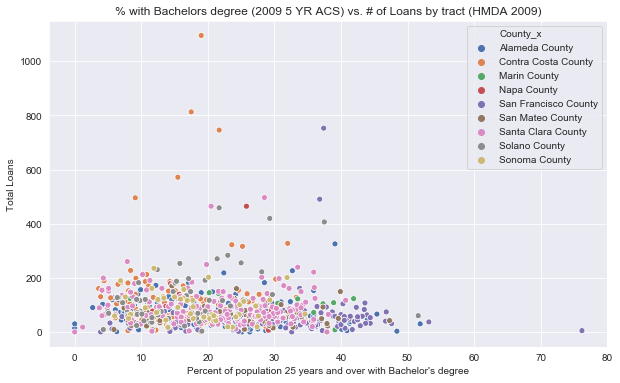

In [62]:

plt.figure(figsize=(10,6))
plt.title('% with Bachelors degree (2009 5 YR ACS) vs. # of Loans by tract (HMDA 2009)')
plot = sns.scatterplot(allvars_2009['Percent of population 25 years and over with Bachelor\'s degree'], allvars_2009['Total Loans'],
     hue = allvars_2009["County_x"], legend='brief', markers='p', palette= "deep")          
plt.legend(bbox_to_anchor=(1,1), loc=1)



plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/bach_vs_loans_09.png')


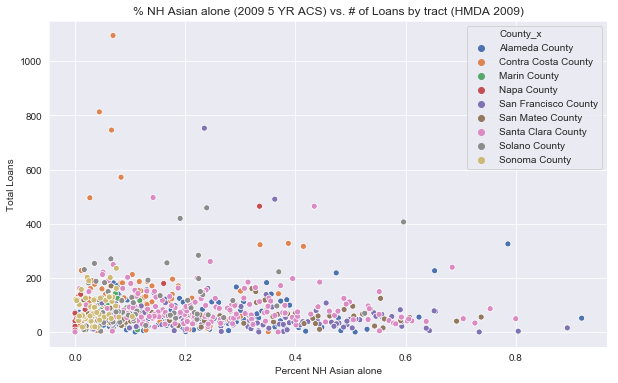

In [66]:
plt.figure(figsize=(10,6))
plt.title('% NH Asian alone (2009 5 YR ACS) vs. # of Loans by tract (HMDA 2009)')
plot = sns.scatterplot(allvars_2009['Percent NH Asian alone'], allvars_2009['Total Loans'],
     hue = allvars_2009["County_x"], legend='brief', markers='p', palette= "deep")          
plt.legend(bbox_to_anchor=(1,1), loc=1)

#plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/nha_vs_loans_09.png')


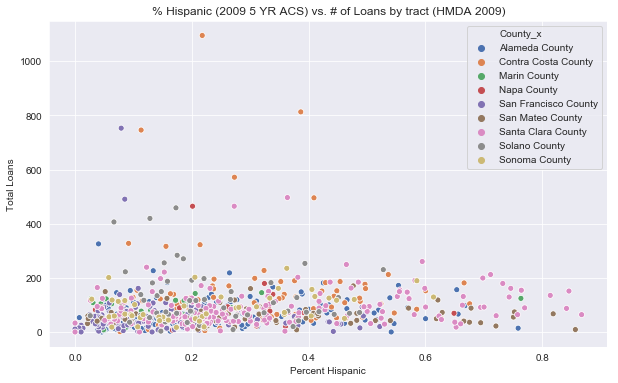

In [63]:
plt.figure(figsize=(10,6))
plt.title('% Hispanic (2009 5 YR ACS) vs. # of Loans by tract (HMDA 2009)')
plot = sns.scatterplot(allvars_2009['Percent Hispanic'], allvars_2009['Total Loans'],
     hue = allvars_2009["County_x"], legend='brief', markers='p', palette= "deep")          
plt.legend(bbox_to_anchor=(1,1), loc=1)


plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/hispanic_vs_loans_09.png')

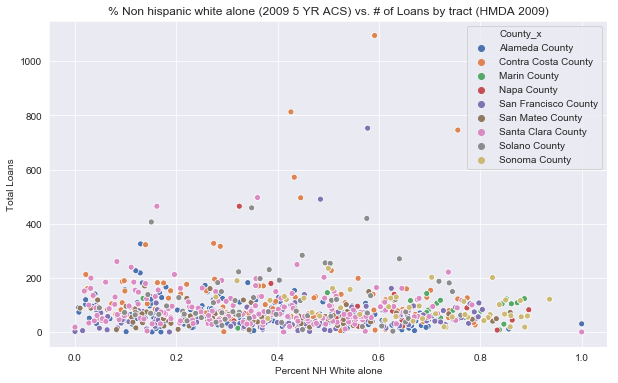

In [68]:
plt.figure(figsize=(10,6))
plt.title('% Non hispanic white alone (2009 5 YR ACS) vs. # of Loans by tract (HMDA 2009)')
plot = sns.scatterplot(allvars_2009['Percent NH White alone'], allvars_2009['Total Loans'],
     hue = allvars_2009["County_x"], legend='brief', markers='p', palette= "deep")          
plt.legend(bbox_to_anchor=(1,1), loc=1)


plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/nhw_vs_loans_09.png')

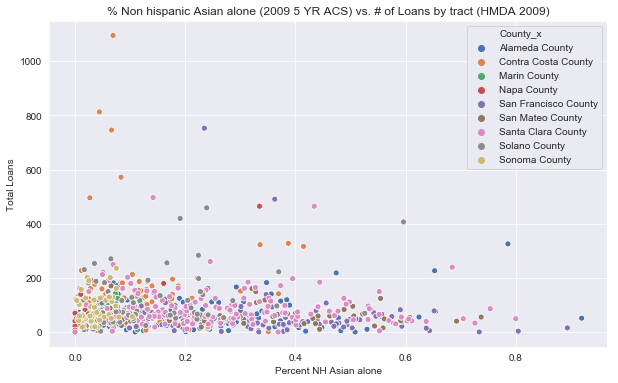

In [73]:
plt.figure(figsize=(10,6))
plt.title('% Non hispanic Asian alone (2009 5 YR ACS) vs. # of Loans by tract (HMDA 2009)')
plot = sns.scatterplot(allvars_2009['Percent NH Asian alone'], allvars_2009['Total Loans'],
     hue = allvars_2009["County_x"], legend='brief', markers='p', palette= "deep")          
plt.legend(bbox_to_anchor=(1,1), loc=1)


plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/nha_vs_loans_09.png')

In [37]:
LI = allvars_2009[allvars_2009['CRA'] == 1]
HI = allvars_2009[allvars_2009['CRA'] == 0]


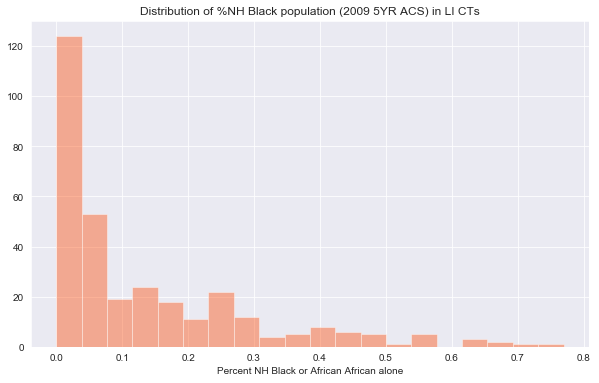

In [49]:


plt.figure(figsize=(10,6))
plt.title('Distribution of %NH Black population (2009 5YR ACS) in LI CTs')
sns.distplot(LI['Percent NH Black or African African alone'], kde=False, color='orangered', bins=20);
plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/LI_nhb_dist_09.png')


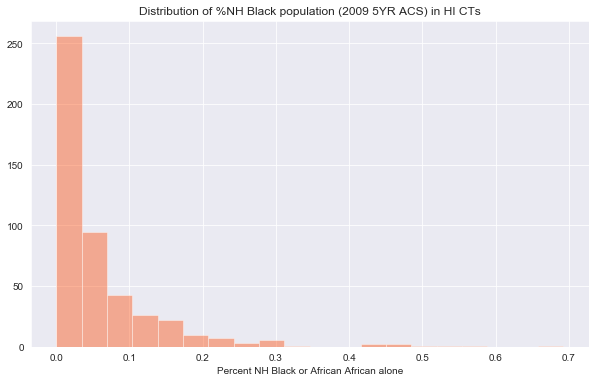

In [50]:
plt.figure(figsize=(10,6))
plt.title('Distribution of %NH Black population (2009 5YR ACS) in HI CTs')
sns.distplot(HI['Percent NH Black or African African alone'], kde=False, color='orangered', bins=20);
plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/HI_nhb_dist_09.png')


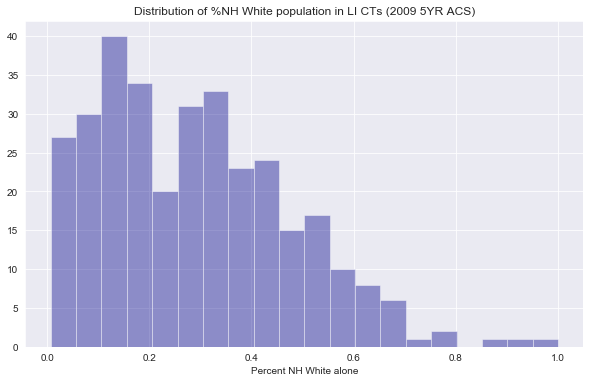

In [52]:
plt.figure(figsize=(10,6))
plt.title('Distribution of %NH White population in LI CTs (2009 5YR ACS)')
sns.distplot(LI['Percent NH White alone'], kde=False, color='darkblue', bins=20);

plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/LI_nhw_dist_09.png')

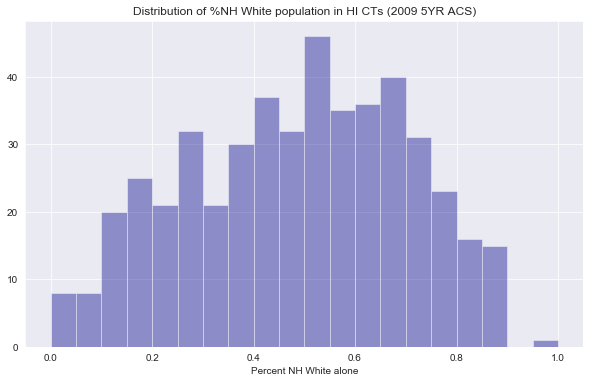

In [54]:
plt.figure(figsize=(10,6))
plt.title('Distribution of %NH White population in HI CTs (2009 5YR ACS)')
sns.distplot(HI['Percent NH White alone'], kde=False, color='darkblue', bins=20);

plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/HI_nhw_dist_09.png')


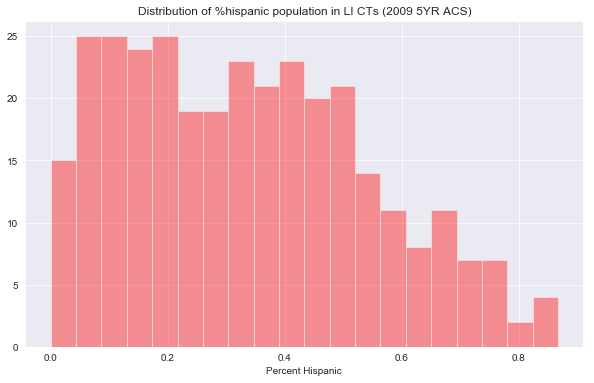

In [56]:
plt.figure(figsize=(10,6))
plt.title('Distribution of %hispanic population in LI CTs (2009 5YR ACS)')
sns.distplot(LI['Percent Hispanic'], kde=False, color='red', bins=20);

plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/LI_h_dist_09.png')

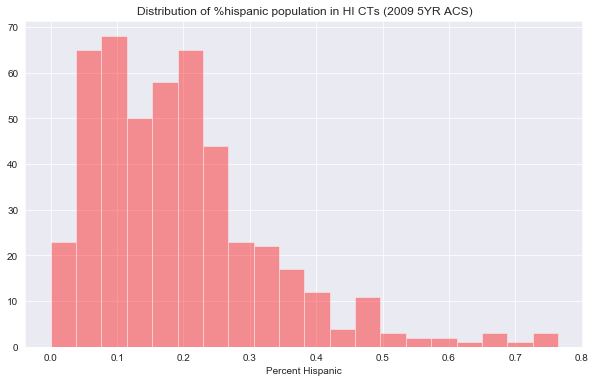

In [60]:
plt.figure(figsize=(10,6))

plt.title('Distribution of %hispanic population in HI CTs (2009 5YR ACS)')
sns.distplot(HI['Percent Hispanic'], kde=False, color='red', bins=20);
plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/HI_h_dist_09.png')

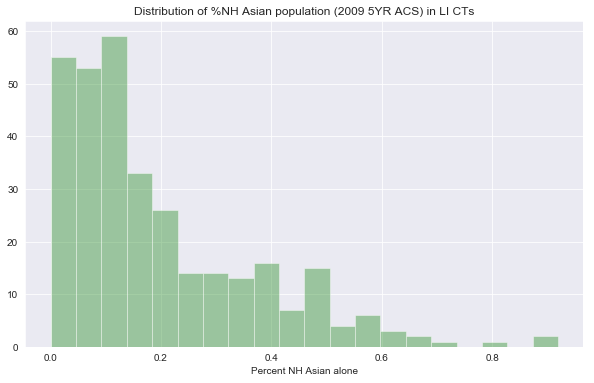

In [70]:
plt.figure(figsize=(10,6))
plt.title('Distribution of %NH Asian population (2009 5YR ACS) in LI CTs')
sns.distplot(LI['Percent NH Asian alone'], kde=False, color='forestgreen', bins=20);
plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/LI_nha_dist_09.png')


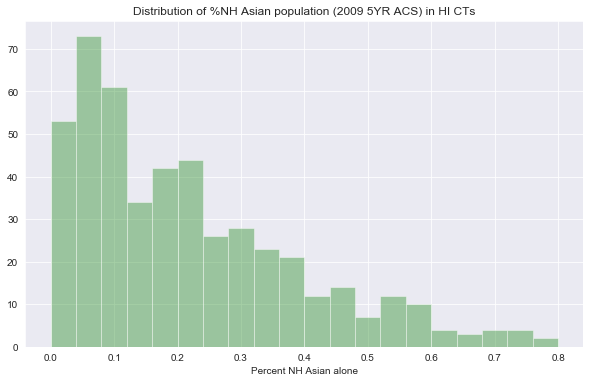

In [72]:
plt.figure(figsize=(10,6))
plt.title('Distribution of %NH Asian population (2009 5YR ACS) in HI CTs')
sns.distplot(HI['Percent NH Asian alone'], kde=False, color='forestgreen', bins=20);
plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/plots/HI_nha_dist_09.png')
